In [45]:
from google.colab import files
uploaded = files.upload()


Saving chartIstanbul.csv to chartIstanbul (1).csv
Saving chartSabiha.csv to chartSabiha (1).csv
Saving HavaDurumu_23.5.xlsx to HavaDurumu_23.5 (1).xlsx


In [46]:
import pandas as pd

# Dosya yolları
sabiha_file = "/content/chartSabiha.csv"
istanbul_file = "/content/chartIstanbul.csv"
weather_file = "/content/HavaDurumu_23.5.xlsx"

# CSV dosyalarını oku
sabiha = pd.read_csv(sabiha_file, sep=';')
istanbul = pd.read_csv(istanbul_file, sep=';')
weather = pd.read_excel(weather_file)

# Sütun adlarını temizle
sabiha.columns = sabiha.columns.str.strip()
istanbul.columns = istanbul.columns.str.strip()
weather.columns = weather.columns.str.strip()

# Tarih formatını düzelt
sabiha['Date'] = pd.to_datetime(sabiha['Date'], format="%d.%m.%Y")
istanbul['Date'] = pd.to_datetime(istanbul['Date'], format="%d.%m.%Y")
weather['Date'] = pd.to_datetime(weather['DateTime'])

# Hava durumu kolonlarını düzenle
weather.rename(columns={
    'Temperature': 'temperature',
    'Humidity': 'humidity',
    'Snow': 'snow',
    'windgust': 'wind_gust',
    'windspeed': 'wind_speed',
    'Pressure': 'pressure',
    'cloudcover': 'cloud_cover',
    'visibility': 'visibility',
    'Condition': 'condition'
}, inplace=True)


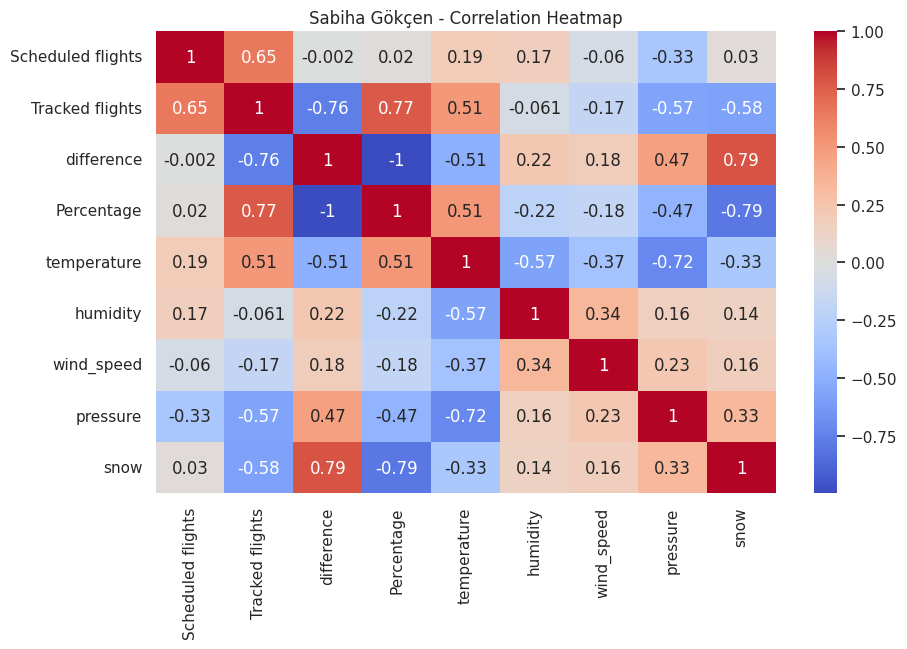

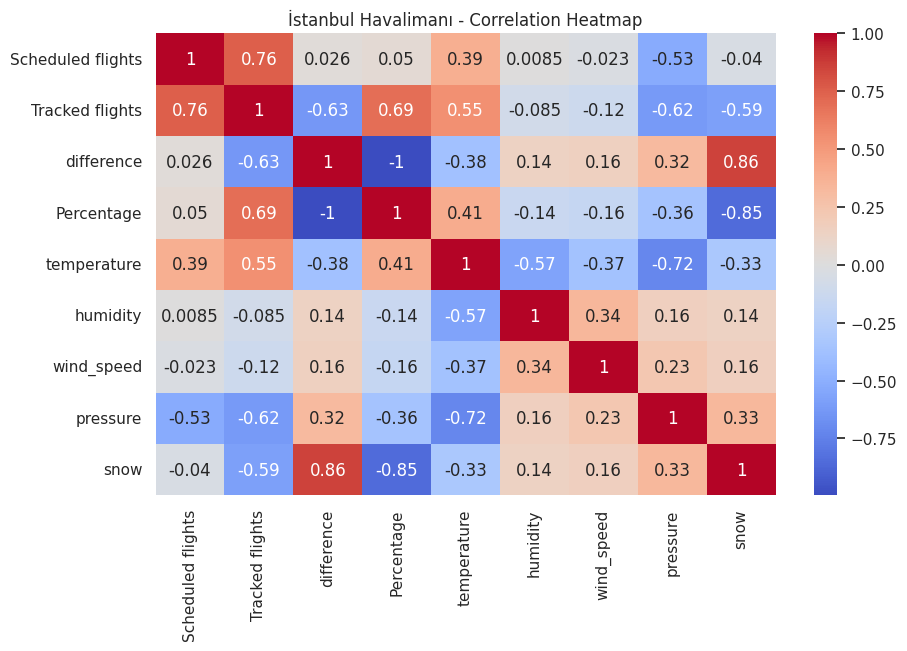

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Percentage'] = merged['Percentage'].str.replace('%','').str.replace(',','.').astype(float) / 100
    merged['difference'] = merged['Scheduled flights'] - merged['Tracked flights']

    corr = merged[['Scheduled flights', 'Tracked flights', 'difference', 'Percentage',
                   'temperature', 'humidity', 'wind_speed', 'pressure', 'snow']].corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f'{airport_name} - Correlation Heatmap')
    plt.show()

plot_heatmap(sabiha.copy(), "Sabiha Gökçen")
plot_heatmap(istanbul.copy(), "İstanbul Havalimanı")


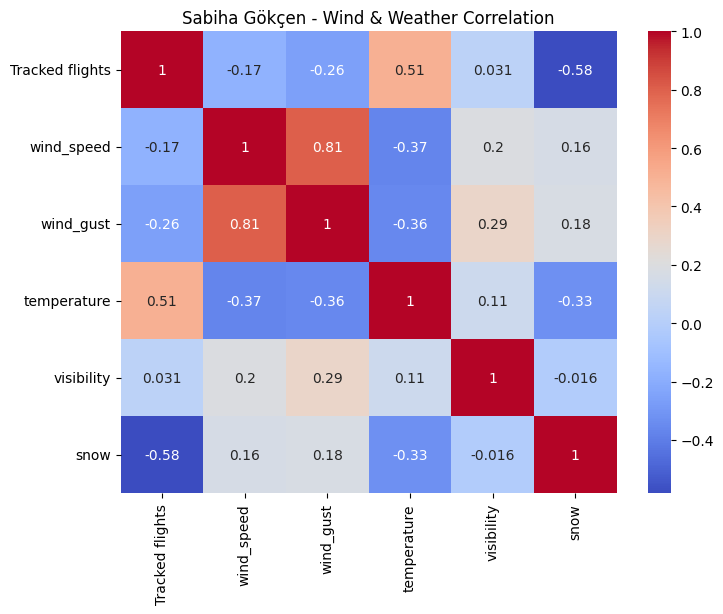

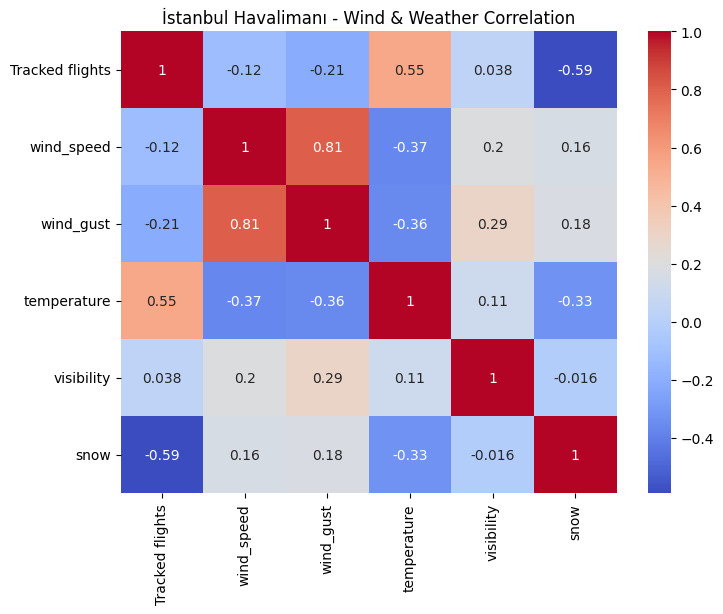

In [17]:
def wind_heatmap(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        merged[['Tracked flights', 'wind_speed', 'wind_gust', 'temperature', 'visibility', 'snow']].corr(),
        annot=True, cmap='coolwarm'
    )
    plt.title(f'{airport_name} - Wind & Weather Correlation')
    plt.show()

wind_heatmap(sabiha.copy(), "Sabiha Gökçen")
wind_heatmap(istanbul.copy(), "İstanbul Havalimanı")


The scatter plots show the relationship between wind conditions and the number of tracked flights. If there's a downward trend, it may suggest that higher wind speeds or wind gusts can be associated with fewer flights being tracked—potentially due to cancellations or delays.

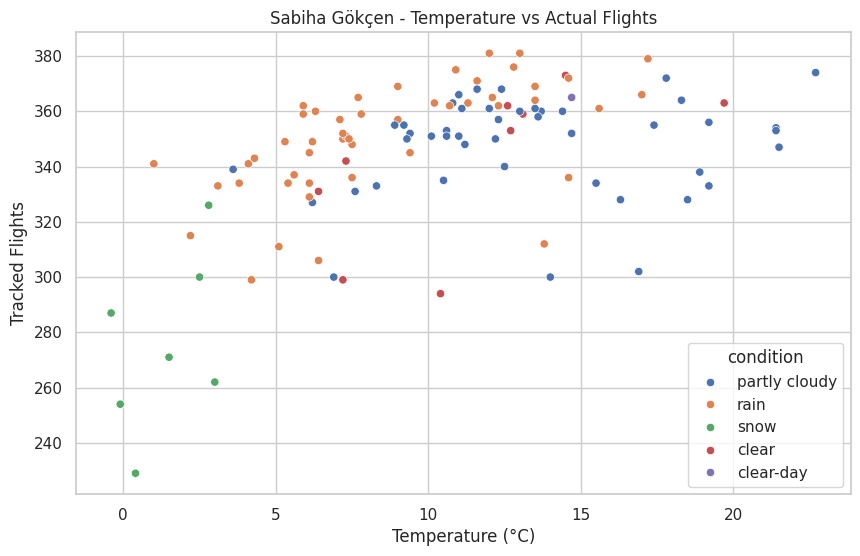

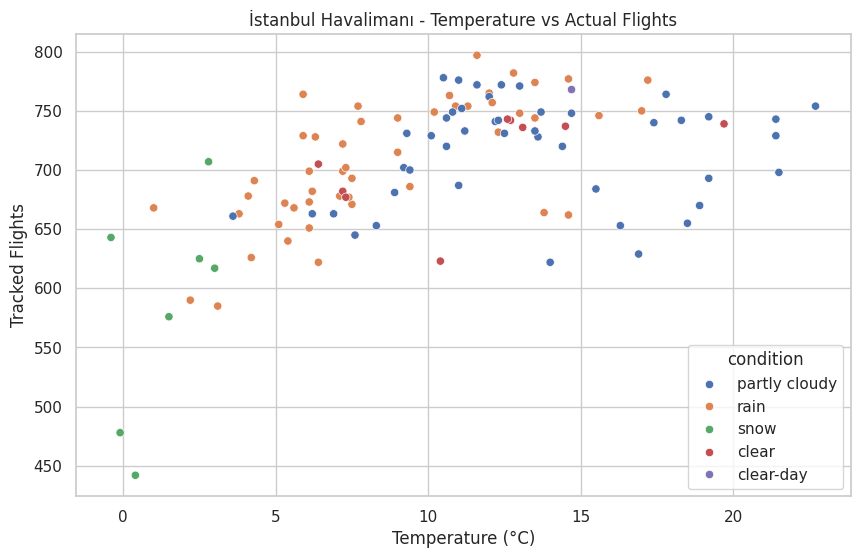

In [48]:
def scatter_plot(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=merged, x='temperature', y='Tracked flights', hue='condition')
    plt.title(f'{airport_name} - Temperature vs Actual Flights')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Tracked Flights')
    plt.show()

scatter_plot(sabiha.copy(), "Sabiha Gökçen")
scatter_plot(istanbul.copy(), "İstanbul Havalimanı")


In the scatter plot above it can be seen that both the temperature and the weather conditions play a big role in flight delays and cancellations. On a clear or a partly cloudy day there are visibly more tracked flights. On the other hand on  a snowy day there are way less tracked flights. This visual shows us that there is a correlation between weather conditions and actual flights.

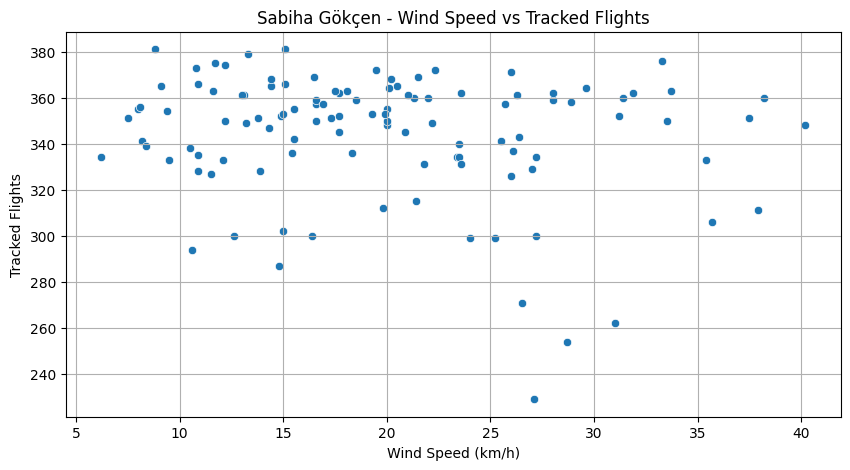

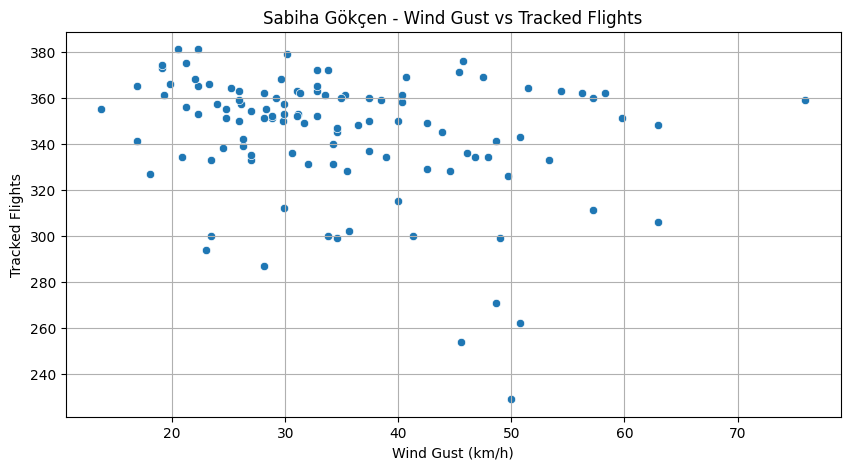

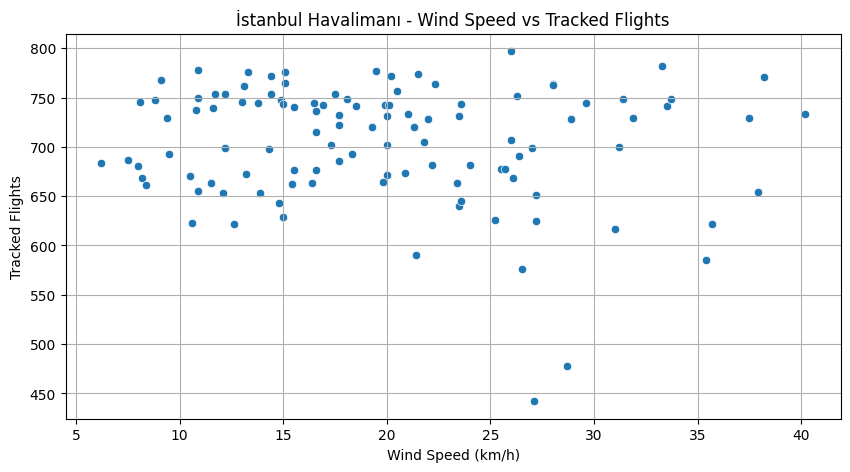

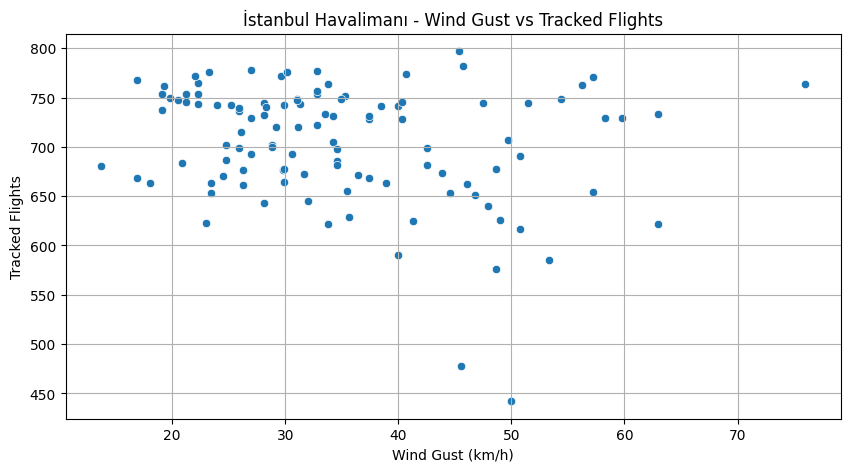

In [18]:
def wind_scatterplots(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')

    # Wind Speed vs Flights
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=merged, x='wind_speed', y='Tracked flights')
    plt.title(f'{airport_name} - Wind Speed vs Tracked Flights')
    plt.xlabel('Wind Speed (km/h)')
    plt.ylabel('Tracked Flights')
    plt.grid(True)
    plt.show()

    # Wind Gust vs Flights
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=merged, x='wind_gust', y='Tracked flights')
    plt.title(f'{airport_name} - Wind Gust vs Tracked Flights')
    plt.xlabel('Wind Gust (km/h)')
    plt.ylabel('Tracked Flights')
    plt.grid(True)
    plt.show()

wind_scatterplots(sabiha.copy(), "Sabiha Gökçen")
wind_scatterplots(istanbul.copy(), "İstanbul Havalimanı")


Wind is another limiting factor in aviation. That is why I wanted to visualize a scatter plot also for the wind speed and wind gusts. A wind gust or just gust is a brief, sudden increase in the wind speed. It usually lasts for less than 20 seconds. In these above scatter plots no obvious correlation can be seen.

In [12]:
from scipy.stats import ttest_rel, pearsonr

def statistical_tests(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')
    merged['Scheduled flights'] = pd.to_numeric(merged['Scheduled flights'], errors='coerce')

    print(f"\n📌 {airport_name} - İstatistiksel Testler:")

    # Paired t-test
    t_stat, p_value = ttest_rel(merged['Scheduled flights'], merged['Tracked flights'], nan_policy='omit')
    print(f"Paired t-test (Scheduled vs Tracked): t={t_stat:.3f}, p={p_value:.3f}")

    # Pearson korelasyon (sıcaklık ve uçuşlar arasında)
    corr, p_temp = pearsonr(merged['temperature'].dropna(), merged['Tracked flights'].dropna())
    print(f"Pearson Correlation (Temperature vs Tracked): r={corr:.3f}, p={p_temp:.3f}")

statistical_tests(sabiha.copy(), "Sabiha Gökçen")
statistical_tests(istanbul.copy(), "İstanbul Havalimanı")



📌 Sabiha Gökçen - İstatistiksel Testler:
Paired t-test (Scheduled vs Tracked): t=5.743, p=0.000
Pearson Correlation (Temperature vs Tracked): r=0.507, p=0.000

📌 İstanbul Havalimanı - İstatistiksel Testler:
Paired t-test (Scheduled vs Tracked): t=14.504, p=0.000
Pearson Correlation (Temperature vs Tracked): r=0.546, p=0.000


In the machine learning model, we used features like wind_speed, wind_gust, temperature, visibility, and snow to predict the number of Tracked flights using a Random Forest Regressor.

The R² score tells us how much of the variance in flight numbers the model can explain.

The RMSE (Root Mean Squared Error) gives us an idea of the typical prediction error.

If the R² is low, it indicates that weather variables alone are not sufficient to explain the variance in flight activity—other factors such as day of the week, air traffic control restrictions, or operational capacity may also play significant roles.

This kind of modeling can help airports and airlines assess how sensitive their operations are to wind-related disruptions and improve planning.



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def run_model(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')

    features = ['temperature', 'humidity', 'wind_speed', 'pressure', 'snow']
    merged = merged.dropna(subset=features + ['Tracked flights'])

    X = merged[features]
    y = merged['Tracked flights']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n🚀 {airport_name} - Model Sonuçları")
    print("R² Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

run_model(sabiha.copy(), "Sabiha Gökçen")
run_model(istanbul.copy(), "İstanbul Havalimanı")



🚀 Sabiha Gökçen - Model Sonuçları
R² Score: 0.405952548221554
MSE: 291.90975217391286

🚀 İstanbul Havalimanı - Model Sonuçları
R² Score: 0.5979960823162322
MSE: 1349.7346130434776


In [22]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def wind_ml_model(flight_df, airport_name):
    merged = pd.merge(flight_df, weather, left_on='Date', right_on='Date', how='left')
    merged['Tracked flights'] = pd.to_numeric(merged['Tracked flights'], errors='coerce')
    merged.dropna(subset=['Tracked flights'], inplace=True)

    features = ['wind_speed', 'wind_gust', 'temperature', 'visibility', 'snow']
    X = merged[features]
    y = merged['Tracked flights']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{airport_name} - Random Forest Results:")
    print("R² Score:", round(r2_score(y_test, y_pred), 3))
        # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    # Calculate RMSE by taking the square root of MSE
    rmse = np.sqrt(mse)
    print("RMSE:", round(rmse, 2))

wind_ml_model(sabiha.copy(), "Sabiha Gökçen")
wind_ml_model(istanbul.copy(), "İstanbul Havalimanı")



Sabiha Gökçen - Random Forest Results:
R² Score: 0.314
RMSE: 18.36

İstanbul Havalimanı - Random Forest Results:
R² Score: 0.516
RMSE: 40.29


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
# Dosya yolları
sabiha_file = "/content/chartSabiha.csv"
istanbul_file = "/content/chartIstanbul.csv"
weather_file = "/content/HavaDurumu_23.5.xlsx"

# CSV dosyalarını oku
sabiha = pd.read_csv(sabiha_file, sep=';')
istanbul = pd.read_csv(istanbul_file, sep=';')
weather = pd.read_excel(weather_file)
# Sütun isimlerini temizle
sabiha.columns = sabiha.columns.str.strip()
weather.columns = weather.columns.str.strip()

# Tarih formatını düzelt
sabiha['Date'] = pd.to_datetime(sabiha['Date'], format='%d.%m.%Y')
weather['Date'] = pd.to_datetime(weather['DateTime'])

# Sütun adlarını yeniden adlandır
sabiha.rename(columns={
    'DateTime': 'date',
    'Scheduled flights': 'scheduled',
    'Tracked flights': 'actual',
    'Percentage': 'percentage'
}, inplace=True)

weather.rename(columns={
    'Temperature': 'temperature',
    'Humidity': 'humidity',
    'Snow': 'snow',
    'windgust': 'wind_gust',
    'windspeed': 'wind_speed',
    'Pressure': 'pressure',
    'cloudcover': 'cloud_cover',
    'visibility': 'visibility',
    'Condition': 'condition'
}, inplace=True)

# Yüzdelik değeri düzelt
sabiha['percentage'] = sabiha['percentage'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Verileri birleştir
df = pd.merge(sabiha, weather, on='Date', how='left')

# Gerekli sayısal sütunları seç
features = ['temperature', 'humidity', 'snow', 'wind_speed', 'wind_gust', 'pressure', 'cloud_cover', 'visibility']
X = df[features]
y = df['actual']


In [32]:
# Eksik verileri temizle
X = X.dropna()
y = y.loc[X.index]

# Train-test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear Regression Model

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)


Random Forest Model

In [34]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


XGBoost

In [35]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


In [36]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R²: {r2:.3f}")

evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)


Linear Regression - MSE: 300.07, R²: 0.389
Random Forest - MSE: 275.80, R²: 0.439
XGBoost - MSE: 354.60, R²: 0.278


Comparing Linear Regression, Random Forest and XGBoost models

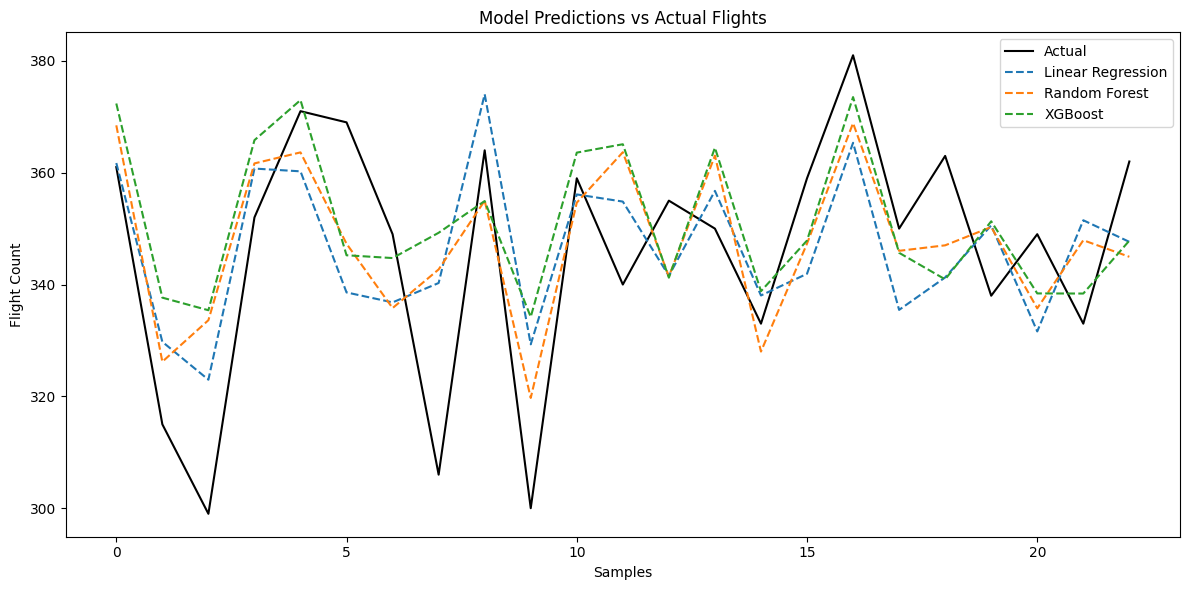

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(lr_pred, label='Linear Regression', linestyle='--')
plt.plot(rf_pred, label='Random Forest', linestyle='--')
plt.plot(xgb_pred, label='XGBoost', linestyle='--')
plt.title("Model Predictions vs Actual Flights")
plt.xlabel("Samples")
plt.ylabel("Flight Count")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


5-Fold Cross-Validaton for the Random Forest

In [40]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores = -cv_scores
print("5-Fold CV MSE Scores:", cv_mse_scores)
print(f"Average CV MSE: {cv_mse_scores.mean():.2f}")


5-Fold CV MSE Scores: [283.55766522 498.62955455 498.98620455 209.19253182 529.61657273]
Average CV MSE: 404.00


Leave-One-Out Cross-Validation (LOOCV)

In [50]:
# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
cv_scores_loo = cross_val_score(rf, X, y, cv=loo, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_loo = -cv_scores_loo
print(f"Average LOOCV MSE: {mse_loo.mean():.2f}")


Average LOOCV MSE: 438.17
